## Import Library

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Menghubungkan google colab dengan goggle drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Grad-Cam Implementation



*   Pahami bagian mana dari gambar yang berperan dalam aktivasi akhir suatu kelas.
*   Proyeksikan fitur-fitur spasial penting dari gambar yang diinput dan analisis apa yang dapat diubah untuk meningkatkan kinerja pengklasifikasi.



### Data Generator

In [ ]:
batch_size = 32
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15)

train_generator = datagen.flow_from_directory('/content/drive/MyDrive/GradCam/data_train/train',
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')

validation_generator = datagen.flow_from_directory('/content/drive/MyDrive/GradCam/data_test/test',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    subset='validation')

Found 346 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


## ConvNet Model (Pretrained VGG-16)

### Model Definition and Hyperparameter Settings

In [ ]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

last = base_model.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,0

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 14,978,370 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

### Model Checkpoints



*   Kurangi laju pembelajaran jika loss validasi tidak menurun setelah 3 epoch berturut-turut.
*   Hentikan pelatihan jika loss validasi tidak menurun setelah 5 epoch berturut-turut.
*   Simpan model terbaik jika memiliki loss validasi yang lebih baik daripada sebelumnya.




In [ ]:
model_name = "model.keras"  # Change the extension to .keras
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

### Model Training

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.5164 - loss: 0.6993
Epoch 1: val_loss improved from inf to 0.69880, saving model to model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 955ms/step - accuracy: 0.5165 - loss: 0.6990 - val_accuracy: 0.5000 - val_loss: 0.6988 - learning_rate: 1.0000e-04
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5278 - loss: 0.6933
Epoch 2: val_loss improved from 0.69880 to 0.69170, saving model to model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 623ms/step - accuracy: 0.5310 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6917 - learning_rate: 1.0000e-04
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6014 - loss: 0.6714
Epoch 3: val_loss did not improve from 0.69170
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.6026 - loss: 0.6699 - val_accuracy: 0.5000 - val_loss: 0.8015 - learning_rate: 1.0000e-04
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5908 - loss: 0.6621
Epoch 4: val_loss did not 

### Learning Curves

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Evalutation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_val = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
print(classification_report(y_val,y_pred))

In [ ]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [ ]:
filenames = validation_generator.filenames

In [ ]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

In [ ]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

## Grad-CAM

### Image Visualization



*   Terklasifikasikan dengan benad jika (A dan P sama)
*   Salah jika klasifikasi (A dan P berbeda)   
*   A : Aktual, P: Prediksi





In [ ]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img


def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    # Loop up to the smaller of 15 or the length of temp_df
    for i in range(min(15, len(temp_df))):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        image = readImage(f"/content/drive/MyDrive/GradCam/data_test/test/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

### Correctly Classified

In [ ]:
display_images(val_df[val_df['Same']==True])

### Misclassified

In [ ]:
display_images(val_df[val_df['Same']!=True])

### Grad-CAM Computation



*   Gradien dihitung dari layer softmax terakhir terhadap layer konvolusi terakhir.
*   Layer keempat dari belakang pada model adalah blok konvolusi terakhir dalam arsitektur VGG-16 yang telah di-finetune.
*   Rata-rata gradien kemudian dikalikan dengan output layer konvolusi terakhir.
*   Output tersebut kemudian dilewatkan melalui fungsi ReLU untuk memastikan semua nilai menjadi positif.







In [ ]:
def make_gradcam_heatmap(img_array, model, pred_index=None):

    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-4].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [ ]:
import matplotlib.cm as cm

In [ ]:
val_df

,filename,actual,predicted,Same
0,dogs/dog.4001.jpg,dogs,dogs,True
1,cats/cat.4005.jpg,cats,cats,True
2,dogs/dog.4005.jpg,dogs,cats,False
3,cats/cat.4003.jpg,cats,cats,True
4,dogs/dog.4004.jpg,dogs,dogs,True
5,cats/cat.4002.jpg,cats,cats,True
6,dogs/dog.4003.jpg,dogs,dogs,True
7,dogs/dog.4002.jpg,dogs,dogs,True
8,cats/cat.4004.jpg,cats,cats,True
9,cats/cat.4001.jpg,cats,dogs,False


### Grad-CAM Projection



*   Heatmap yang dihasilkan menggunakan perhitungan Grad-CAM kemudian diproyeksikan ke gambar asli.
*   Heatmap tersebut menyoroti bagian-bagian penting dari gambar yang menyebabkan aktivasi suatu kelas pada layer softmax terakhir.



In [ ]:
def gradCAMImage(image):
    path = f"//content/drive/MyDrive/GradCam/data_test/test/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

## Result

In [ ]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = val_df[val_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)

    # Get the number of rows in temp_df
    num_rows = len(temp_df)

    # Iterate through the available rows, up to a maximum of 15
    for i in range(min(num_rows, 15)):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [ ]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

<ipython-input-51-18728853e01f>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [ ]:
def display_heatmaps(classified_images, titles):
    plt.figure(figsize=(20, 20))
    n = 0
    num_images = len(classified_images) # Get the actual number of images
    for i in range(min(num_images, 15)): # Iterate up to the number of images or 15, whichever is smaller
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

### Grad-CAM: Correctly Classified

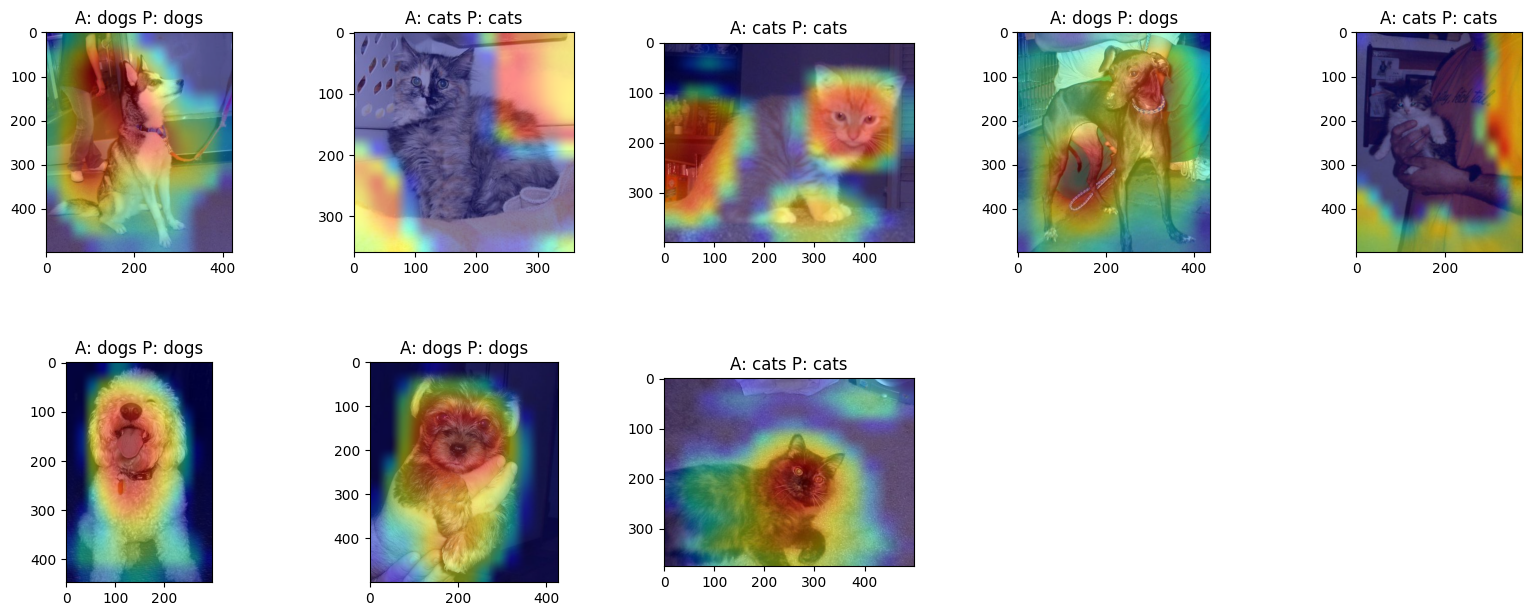

In [ ]:
display_heatmaps(correctly_classified,c_titles)

### Grad-CAM: Incorrectly Classified

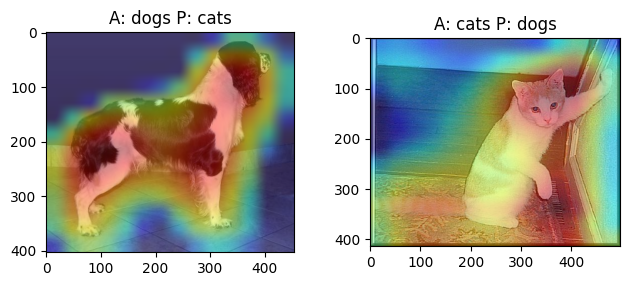

In [ ]:
%matplotlib inline
display_heatmaps(misclassified,m_titles)

## Conclusion

Tujuan notebook ini adalah untuk mendemonstrasikan metode Grad-CAM dan bagaimana metode ini dapat digunakan untuk menginterpretasikan CNN. Inferensi dari visualisasi Grad-CAM dapat digunakan untuk lebih lanjut memperbaiki kesalahan klasifikasi model dan meningkatkan performa model.